# Assignment: SVD Preprocessing on MNIST with Logistic Regression

## Instructions:
In this assignment, you will apply **Singular Value Decomposition (SVD)** as a preprocessing step to the **MNIST dataset** and train a **logistic regression classifier**. You will compare the model performance and training time when using different levels of SVD for dimensionality reduction.

In this assignment, you will need to:
1. Load the MNIST dataset and normalize it.
2. Perform SVD and reduce the dimensions of the data.
3. Train a logistic regression model on the original and SVD-reduced data.
4. Measure and compare the training time and accuracy of the model with varying SVD components.
5. Plot the results and analyze how SVD impacts the performance and efficiency of the model.

***
Your tasks include:
1. Implement SVD algorithm. You are not allowed to directly use SVD implemented by other packages, but you may use functions in NumPy. (Part 2)
2. Explore the accuracy and time performance from different numbers of SVD components. (Part 4)
3. Visualize the accuracy, time performance and top 5 singular vectors in the dataset, analyze and explain which number of SVD component looks best to you? (Part 4,5&6) Hint: singular vectors should be reshaped to 28x28 images for visualization.
***
**Note that you may not import any other function or package.** Let's get started!


## Part 1: Load the MNIST dataset and preprocess the data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)

# Each pixel is value from 0 to 255 (black to white)
X = mnist.data
y = mnist.target

# Normalize the data to values between 0 and 1
X = X / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading MNIST dataset...


## Part 2: Implement SVD for Dimensionality Reduction

In [4]:
def get_A_t_A(dataset):
    A_transpose = np.transpose(dataset)
    A_t_A = np.dot(A_transpose, dataset)
    return A_t_A


In [6]:
def get_s_matrix(A_t_A):
    # get eigenvalues of A^T A
    eigenvalues, _ = np.linalg.eig(A_t_A)

    # sort eigenvalues in descending order
    eigenvalues_desc = np.sort(eigenvalues)[::-1]

    # ensure all eigenvalues are non-negative (take absolute value to avoid numerical issues)
    eigenvalues_desc = np.real(eigenvalues_desc)
    eigenvalues_desc = np.where(eigenvalues_desc < 0, 0, eigenvalues_desc)  # Set negative values to 0

    # set a tolerance to filter out very small eigenvalues
    tolerance = 1e-10
    eigenvalues_desc = np.where(eigenvalues_desc < tolerance, 0, eigenvalues_desc)

    # take square root of eigenvalues to get singular values
    singular_values = np.sqrt(eigenvalues_desc)

    # # place in diagonal matrix
    # s_matrix = np.diag(singular_values) # this did not do what I thought it did

    # place in diagonal matrix
    s_dim = len(singular_values)
    s_matrix = np.zeros((s_dim, s_dim), int)
    # print(f"0 square matrix: {s_matrix}")

    np.fill_diagonal(s_matrix, singular_values)

    # print(f"s matrix: {s_matrix}")

    # for i in range(len(singular_values)):
    #     s_matrix[i][i] = singular_values[i]

    return (s_matrix)


In [7]:
def get_V_t_matrix(A_t_A):
    # Compute eigenvalues and eigenvectors of A_t_A
    eigenvalues, eigenvectors = np.linalg.eig(A_t_A)

    # Get index of descending eigenvalues
    indx_desc = np.argsort(eigenvalues)[::-1]

    # Sort eigenvectors in the same order as descending eigenvalues
    v_matrix = eigenvectors[:, indx_desc]

    # Ensure that only the real part is kept to avoid complex numbers
    v_matrix = np.real(v_matrix)

    # Transpose the matrix to get V^T
    v_matrix_transpose = np.transpose(v_matrix)
    
    return v_matrix_transpose


In [8]:
# X_train is 56000 × 784
def get_U_matrix(dataset, V_t, S):
    # U = A * V * S_inv
    S_inv = np.linalg.pinv(S) 
    U_matrix = np.dot(dataset, np.dot(np.transpose(V_t), S_inv))
    
    return U_matrix


In [9]:
# returns components U, S, and V^T
def get_svd(dataset, n_components):
    A_t_A = get_A_t_A(dataset)

    # get first n columns of S
    S_matrix = get_s_matrix(A_t_A)
    # S_reduced = S_matrix[:,:n_components]
    S_reduced_values = np.diag(S_matrix[:n_components])
    new_dims = len(S_reduced_values)
    S_reduced = np.zeros((new_dims, new_dims), int)
    np.fill_diagonal(S_reduced, S_reduced_values)

    # select first n rows
    V_t_matrix = get_V_t_matrix(A_t_A)
    V_t_reduced = V_t_matrix[:n_components, :]

    # select first n columns
    U_matrix = get_U_matrix(dataset, V_t_matrix, S_matrix)[:,:n_components]

    # print(f"{dataset} = \n{U_matrix} * \n{S_reduced} * \n{V_t_matrix} ")
    return U_matrix, S_reduced, V_t_reduced

In [10]:
# A = USV^T
def apply_svd_custom(X_train, X_test, n_components):
    U_train, S_train, Vt_train = get_svd(X_train, n_components)
    U_test, S_test, Vt_test = get_svd(X_test, n_components)

    # dimenson mismatch issues?? 
    print(f"U_train dims are: {U_train.shape}\nS_train dims are {S_train.shape}\nVt_train dims are {Vt_train.shape}")
    train_reduced = np.dot(U_train, np.dot(S_train, Vt_train))
    test_reduced = np.dot(U_test, np.dot(S_test, Vt_test))

    return train_reduced, test_reduced

## Part 3: Train Logistic Regression and Measure Performance

In [11]:
# Function to train logistic regression and track training time
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='saga', random_state=42, multi_class='multinomial')
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time


## Part 4: Experiment with Different Levels of SVD

Now, apply SVD with varying numbers of components and observe how the dimensionality reduction impacts the model's performance. Record both the accuracy and training time for each number of components.


In [13]:
import csv

svd_components = [2, 4, 16, 32, 64, 128, 256, 384, 512, 646, 780]

# Store the results
results = []

print("Training models with different levels of SVD preprocessing...")
for n_components in svd_components:
    print(f"Applying custom SVD with {n_components} components...")
    
    # Apply SVD to the training and test sets
    # Call apply_svd_custom() here...
    X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
    
    # Train the logistic regression model and get accuracy and training time
    accuracy, training_time = train_logistic_regression(X_train_svd, y_train, X_test_svd, y_test)

    results.append([accuracy, training_time])
    # save so i don't have to do it again
    with open("results.csv", mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([n_components, accuracy, training_time])
    
    print(f"SVD components: {n_components}, Accuracy: {accuracy:.4f}, Training time: {training_time:.4f} seconds")


Training models with different levels of SVD preprocessing...
Applying custom SVD with 2 components...
U_train dims are: (56000, 2)
S_train dims are (2, 2)
Vt_train dims are (2, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 2, Accuracy: 0.3433, Training time: 9.7377 seconds
Applying custom SVD with 4 components...
U_train dims are: (56000, 4)
S_train dims are (4, 4)
Vt_train dims are (4, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 4, Accuracy: 0.5361, Training time: 10.3582 seconds
Applying custom SVD with 16 components...
U_train dims are: (56000, 16)
S_train dims are (16, 16)
Vt_train dims are (16, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 16, Accuracy: 0.8530, Training time: 12.7931 seconds
Applying custom SVD with 32 components...
U_train dims are: (56000, 32)
S_train dims are (32, 32)
Vt_train dims are (32, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 32, Accuracy: 0.8979, Training time: 32.1450 seconds
Applying custom SVD with 64 components...
U_train dims are: (56000, 64)
S_train dims are (64, 64)
Vt_train dims are (64, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 64, Accuracy: 0.9137, Training time: 92.4545 seconds
Applying custom SVD with 128 components...
U_train dims are: (56000, 128)
S_train dims are (128, 128)
Vt_train dims are (128, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 128, Accuracy: 0.9195, Training time: 222.3387 seconds
Applying custom SVD with 256 components...
U_train dims are: (56000, 256)
S_train dims are (256, 256)
Vt_train dims are (256, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 256, Accuracy: 0.9214, Training time: 261.8107 seconds
Applying custom SVD with 384 components...
U_train dims are: (56000, 384)
S_train dims are (384, 384)
Vt_train dims are (384, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 384, Accuracy: 0.9195, Training time: 260.0073 seconds
Applying custom SVD with 512 components...
U_train dims are: (56000, 512)
S_train dims are (512, 512)
Vt_train dims are (512, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 512, Accuracy: 0.9206, Training time: 298.7577 seconds
Applying custom SVD with 646 components...
U_train dims are: (56000, 646)
S_train dims are (646, 646)
Vt_train dims are (646, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 646, Accuracy: 0.9209, Training time: 322.1654 seconds
Applying custom SVD with 780 components...
U_train dims are: (56000, 780)
S_train dims are (780, 780)
Vt_train dims are (780, 784)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SVD components: 780, Accuracy: 0.9209, Training time: 318.9944 seconds


## Part 5: Visualize and Analyze the Results

Finally, plot the accuracy, training time as a function of the number of SVD components, and top 5 singular vectors. This will help you understand the trade-off between dimensionality reduction, accuracy, and model training time, and how SVD generally works. Hint: singular vectors should be reshaped to 28x28 images for visualization.


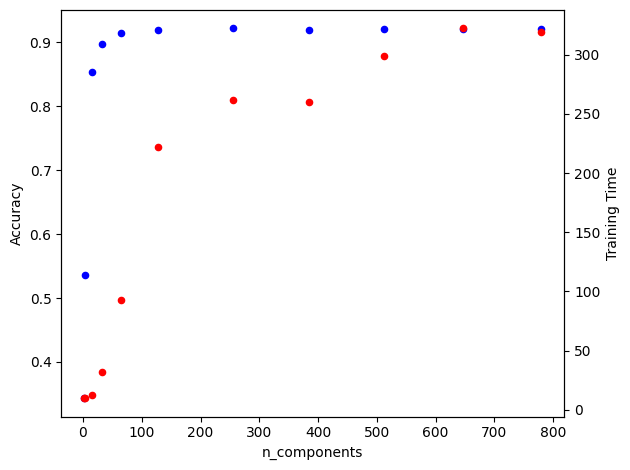

In [50]:
## Your implementation here...
## You may add necessary lines in Part 4 to access data for visualization
import pandas as pd
import matplotlib.pyplot as plt 

results = pd.read_csv("results.csv")
results 

fig, ax1 = plt.subplots()

ax1.scatter(x=results['n_components'], y=results['accuracy'], s=20, color='blue', label='accuracy')
ax1.set_xlabel('n_components')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.scatter(x=results['n_components'], y=results['training_time'], s=20, color='red', label='training time')
ax2.set_ylabel('Training Time')
ax2.tick_params(axis='y')

# ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
fig.tight_layout()

# RED is training time
# BLUE is accuracy
# sorry i can't figure out how to not make the legends overlap


### First five rows of the dataset at the various svd ranks I tested:

U_train dims are: (56000, 780)
S_train dims are (780, 780)
Vt_train dims are (780, 784)


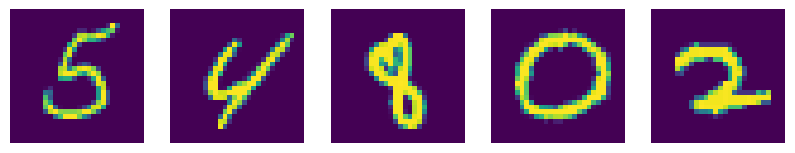

In [56]:
n_components = 780

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 646)
S_train dims are (646, 646)
Vt_train dims are (646, 784)


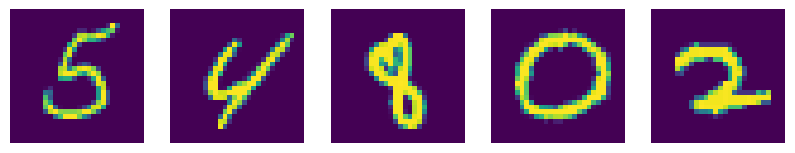

In [57]:
n_components = 646

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 512)
S_train dims are (512, 512)
Vt_train dims are (512, 784)


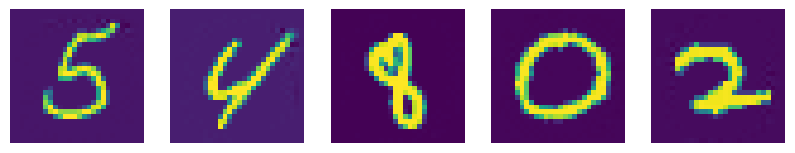

In [58]:
n_components = 512

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 384)
S_train dims are (384, 384)
Vt_train dims are (384, 784)


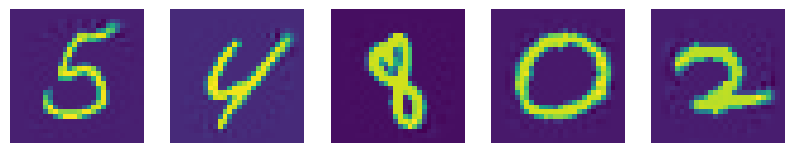

In [59]:
n_components = 384

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 256)
S_train dims are (256, 256)
Vt_train dims are (256, 784)


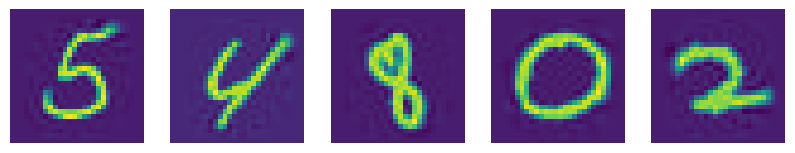

In [60]:
n_components = 256

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 128)
S_train dims are (128, 128)
Vt_train dims are (128, 784)


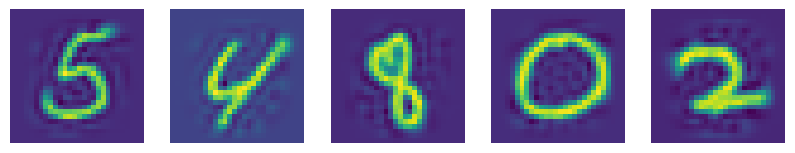

In [61]:
n_components = 128

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 64)
S_train dims are (64, 64)
Vt_train dims are (64, 784)


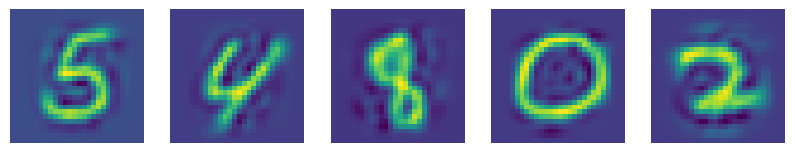

In [62]:
n_components = 64

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 32)
S_train dims are (32, 32)
Vt_train dims are (32, 784)


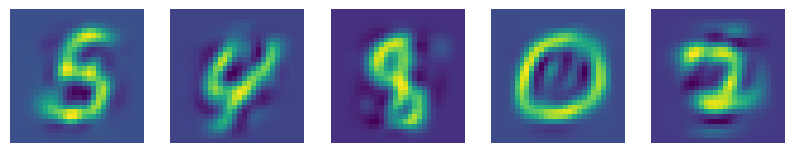

In [63]:
n_components = 32

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 16)
S_train dims are (16, 16)
Vt_train dims are (16, 784)


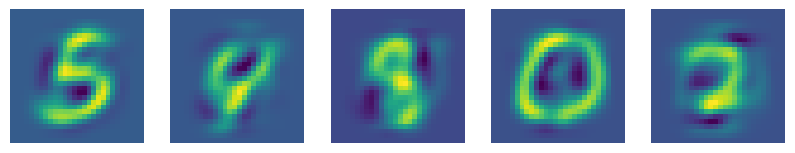

In [64]:
n_components = 16

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 4)
S_train dims are (4, 4)
Vt_train dims are (4, 784)


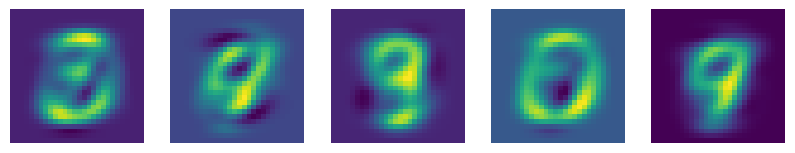

In [65]:
n_components = 4

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

U_train dims are: (56000, 2)
S_train dims are (2, 2)
Vt_train dims are (2, 784)


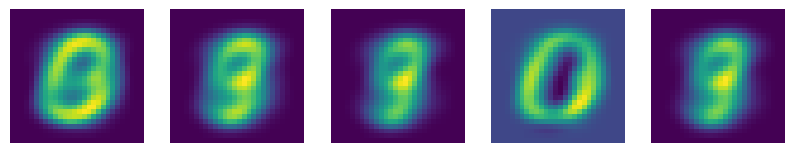

In [66]:
n_components = 2

X_train_svd, X_test_svd  = apply_svd_custom(X_train, X_test, n_components)
first_five_images = X_train_svd[:5]

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image = np.array(first_five_images[i]).reshape(28, 28)
    
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## Part 6: Analyze / Conclusion 

YOUR ANSWER: 

As expected, lower n_components, or SVD ranks, lead to less accurate results but less training time. Lower ranks meant images have lower resolution, as shown by the visual images, and it is harder to distinguish characteristics of each number. However, increasing rank will only increase accuracy at a certain rate, before improvements diminish, which we can see after n_components=512, the marginal improvements decreases, meaning there is an ideal trade-off between time and accuracy at that point. We also see this point clearly, as the images look best at around ranks higher than 384, and gets indistinguishable very fast.